In [ ]:
!wget -O ds001420-download.zip https://www.dropbox.com/sh/h8z155ezh7py8b1/AAC4tMz_SGQbcoJ9wr0cuaM6a?dl=1 ds001420-download
!unzip ds001420-download.zip
!git clone https://www.github.com/tfunck/hacking_hour

--2021-05-25 10:44:00--  https://www.dropbox.com/sh/h8z155ezh7py8b1/AAC4tMz_SGQbcoJ9wr0cuaM6a?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.11.18, 2620:100:6050:18::a27d:b12
Connecting to www.dropbox.com (www.dropbox.com)|162.125.11.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/dl/h8z155ezh7py8b1/AAC4tMz_SGQbcoJ9wr0cuaM6a [following]
--2021-05-25 10:44:01--  https://www.dropbox.com/sh/dl/h8z155ezh7py8b1/AAC4tMz_SGQbcoJ9wr0cuaM6a
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc32cae5dbf06bf6bf7408bd52f3.dl.dropboxusercontent.com/zip_download_get/AyhrmCm8fXlH6fb2rMaO87eCzoVJH_1CDRh5_JYBsKmijUbxmApUKNRQCYCFZEZw477YJ5Rzp-mEFSmj8wZcrPB-1wOB9KOT2ngke4wMAv69xw?dl=1# [following]
--2021-05-25 10:44:02--  https://uc32cae5dbf06bf6bf7408bd52f3.dl.dropboxusercontent.com/zip_download_get/AyhrmCm8fXlH6fb2rMaO87eCzoVJH_1CDRh5_JYBsKmijUbxmApUKNRQCYCFZEZw477YJ5Rzp-m

In [ ]:
!git clone https://www.github.com/tfunck/hacking_hour

In [2]:
### Recap

# Pandas is a Python library for manipulating "data frames"
import pandas as pd

#Pandas data frames can be 
# 1. from lists
df0 = pd.DataFrame( [['a','b'],[2,3]], columns=['A','B']) 
# 2. from dictionaries
df1 = pd.DataFrame( {'A':[1,2],'B':[2,3]} )
df1.to_csv('df1.csv', index=False)
# 3. read from excel or .csv files
df2 = pd.read_csv('df1.csv')

#You can create new columns in your data frame:
df2['C']=[5,6]

# You can index the data frame using booleans with .loc 
print(df2)
print(df2.loc[ df2['C'] == 5 , : ] )

# and integers with .iloc
print(df2.iloc[1,:])

# You can also apply functions to specific columns
df2['C'] = df2['C'].apply(lambda i : i % 2 == 0)
print(df2)

# pyplot and seaborn are two of the most popular plotting libraries in python
import matplotlib.pyplot as plt
plt.scatter(df2['A'], df2['B']) #scatter plot
plt.plot(df2['A'], df2['B'], c='r') #line plot


# For standard statistical analysis, scipy.stats has what you need
from scipy import stats
print(stats.f_oneway(df2['A'],df2['B'],df2['C']))


   A  B  C
0  1  2  5
1  2  3  6
   A  B  C
0  1  2  5
A    2
B    3
C    6
Name: 1, dtype: int64
   A  B      C
0  1  2  False
1  2  3   True
F_onewayResult(statistic=4.0, pvalue=0.14242717305466185)


In [3]:
### Outline: Basic Image Processing

# 1. Segmentation

# 2. Morphological Operations

# 3. Filtering

# 4. Resampling


In [4]:
### Exercise
# Write a function called "get_section" that:  
#   1. takes a filename as input
#   (BONUS 1.1: Check if the file exists)
#   2. loads the file with the load() function in the nibabel library
#   3. uses the .get_fdata() method to load the image volume as a numpy array
#   4. selects a section number within the volume
#   5. uses the section number to index the volume
#   6. returns the selected section from the volume


import os
import nibabel as nib
import numpy as np

brain_filename='hacking_hour/data/full16_1000um_optbal.nii.gz'


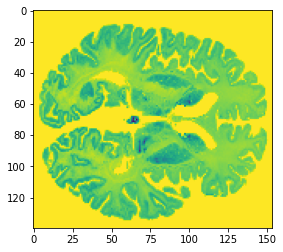

In [5]:





### Solution
import os
import nibabel as nib
import numpy as np


def get_section(filename):
    if os.path.exists(filename):
        vol = nib.load(filename).get_fdata()
        z = int(vol.shape[2]/2)
        section = vol[:,:,z]
        return section
    else :
        print('Error: file does not exist', filename)
        return 1
    
brain_filename='hacking_hour/data/full16_1000um_optbal.nii.gz'
section = get_section(brain_filename)
plt.imshow(section)

Error: file does not exist ds001420-download/sub-01/ses-baseline/anat/sub-01_ses-baseline_space-pet_T1w_uint16.nii.gz
Error: file does not exist ds001420-download/sub-01/ses-baseline/pet/sub-01_ses-baseline_pet.nii.gz


TypeError: Invalid shape () for image data

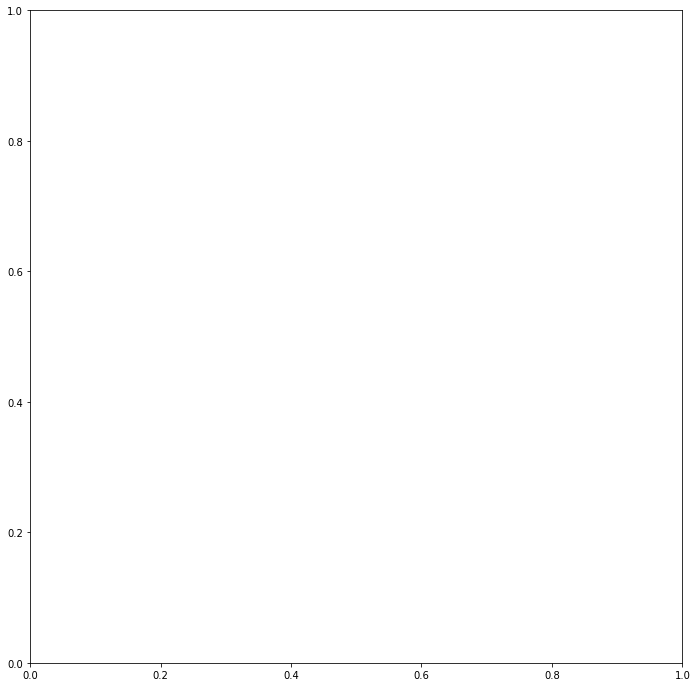

In [6]:

mri_fn='ds001420-download/sub-01/ses-baseline/anat/sub-01_ses-baseline_space-pet_T1w_uint16.nii.gz'
mri_section = get_section(mri_fn)

pet_fn='ds001420-download/sub-01/ses-baseline/pet/sub-01_ses-baseline_pet.nii.gz'
pet_section = get_section(pet_fn)

plt.figure(figsize=(12,12))
plt.imshow(mri_section,cmap='Greys')
plt.imshow(pet_section, alpha=0.5)

# Goal: normalize the values in the PET image based on the average intensity in the WM

In [ ]:
### 3. Segmentation

# k-means
# sklearn is a machine learning library with lots of different algorithms
# these algorithms use similar formatting, so once you know one, it's easy to use the others

from sklearn.cluster import KMeans
n=3

section_vector = mri_section.reshape(-1,1)

starting_values=np.array([0,section_vector.mean(), section_vector.max()]).reshape(-1,1)

km = KMeans(n, init=starting_values)
mri_cls_vector = km.fit_predict(section_vector)
mri_cls = mri_cls_vector.reshape(mri_section.shape)

plt.imshow(mri_cls)
plt.show()

In [ ]:
### Exercise
# Run k-means on "mri_section" with different number of classes and display the results with plt.subplot




In [ ]:
### Solution

from sklearn.cluster import KMeans

section_vector = mri_section.reshape(-1,1)
mri_cls_4 = KMeans(4).fit_predict(section_vector).reshape(mri_section.shape)
mri_cls_2 = KMeans(2).fit_predict(section_vector).reshape(mri_section.shape)

plt.subplot(1,2,1)
plt.imshow(mri_cls_2)
plt.subplot(1,2,2)
plt.imshow(mri_cls_4)
plt.show()

In [ ]:
# Creating a white matter mask
# There are three values in the mri_cls section 0=background, 1=WM+skull, 2=GM+skull
# Goal : get just the WM so that we can use it to process the associated PET image

mri_wm = np.copy(mri_cls)
mri_gm = np.copy(mri_cls)

mri_wm[ mri_wm !=2 ] = 0
mri_gm[ mri_gm !=1 ] = 0 

plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.imshow(mri_wm)
plt.subplot(1,2,2)
plt.imshow(mri_gm)

# still have to find a way to get rid of the skull...

In [ ]:
# Otsu thresholding 
# Otsu thresholding is a simple and powerful technique to seperate background and foreground.
# It basically uses the image's histogram to find the optimal threshold value for spliting the image in two

from skimage.filters import threshold_otsu

pet_cls = np.zeros(pet_section.shape)

t = threshold_otsu(pet_section)

mask = pet_section > t

pet_cls[mask] = 1

plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.imshow(pet_section)
plt.subplot(1,2,2)
plt.imshow(pet_cls)





In [ ]:
### Morphological operations

# Discrete, binary images (like segmentations) can be manipulated to change the shape, or morphology,
# of the shapes in the image

# morphological dilation
# dilation will expand the border of the pixels, once per iteration

from skimage.morphology import binary_dilation
wm_dilated_1 = binary_dilation(mri_wm)
wm_dilated_2 = binary_dilation(wm_dilated_1)
wm_dilated_3 = binary_dilation(wm_dilated_2)

plt.figure(figsize=(12,12))

plt.subplot(3,1,1)
plt.imshow(wm_dilated_1)
plt.subplot(3,1,2)
plt.imshow(wm_dilated_2)
plt.subplot(3,1,3)
plt.imshow(wm_dilated_3)

In [ ]:
# morphological erosion
# erosion will expand the border of the pixels, once per iteration

from skimage.morphology import  binary_erosion
wm_eroded_1 = binary_erosion(mri_wm)
wm_eroded_2 = binary_erosion(wm_eroded_1)
wm_eroded_3 = binary_erosion(wm_eroded_2)

plt.figure(figsize=(12,12))

plt.subplot(3,1,1)
plt.imshow(wm_eroded_1)
plt.subplot(3,1,2)
plt.imshow(wm_eroded_2)
plt.subplot(3,1,3)
plt.imshow(wm_eroded_3)

In [ ]:
### Excercise :
# Write a function that will apply binary dilation or erosion for a number of iterations defined by user
# Inputs = array, number of iterations, variable to indicate whether to use dilation or erosion

#def morph_iter(ar, n, method):
test_ar = np.zeros([5,5])
test_ar[2,2]=1

In [ ]:





### Solution :
def morph_iter(ar, n, method):
    if n < 0 :
        print('Error: n must be greater >= 0, but got',n)
        
    if method == 'erosion' :
        morph = binary_erosion
    elif method == 'dilation' :
        morph = binary_dilation
    else :
        print('Error: method not recognized. Must be "erosion" or "dilation" but got', method)
    
    for i in range(n):
        ar=morph(ar)
    
    return ar

print(test_ar)
morphed_ar = morph_iter(test_ar, 3, 'dilation')
print(morphed_ar)

In [ ]:
from skimage.morphology import binary_closing


pet_cls_closed_1 = binary_dilation(binary_erosion(pet_cls))
n_iter = 9
pet_brain = morph_iter( morph_iter(pet_cls_closed_1,n_iter,'dilation'), n_iter, 'erosion')

plt.figure(figsize=(12,12))
plt.subplot(1,3,1)
plt.imshow(pet_cls)
plt.subplot(1,3,2)
plt.imshow(pet_cls_closed_1)
plt.subplot(1,3,3)
plt.imshow(pet_brain)


In [ ]:
print('MRI WM mask dimensions = ', mri_wm.shape)
print('PET brain mask dimensions = ', pet_brain.shape)

pet_wm = (mri_wm * pet_brain).astype(bool)
pet_gm = (mri_gm * pet_brain).astype(bool)

plt.figure(figsize=(16,12))
plt.subplot(1,4,1)
plt.imshow(mri_wm)
plt.subplot(1,4,2)
plt.imshow(pet_brain)
plt.subplot(1,4,3)
plt.imshow(pet_wm)
plt.subplot(1,4,4)
plt.imshow(pet_gm)



In [ ]:
# Downsampling a discrete image

pet_wm_eroded = morph_iter(pet_wm,4, 'erosion')


wm_mean = np.mean(pet_section[pet_wm_eroded])


pet_section_norm = pet_section / wm_mean

gm_norm_mean = np.round(np.mean(pet_section_norm[pet_gm]),2)



plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.imshow(pet_section, cmap='hot')
plt.imshow(pet_wm_eroded,alpha=0.65)
plt.subplot(1,2,2)
plt.imshow(pet_section_norm)
plt.colorbar()

print('Mean WM value:', wm_mean)
print(f'For our subject, the GM has {gm_norm_mean} times more binding than the WM.')

In [ ]:
### Excercise

# For the following subjects and sessions, write functions to calculate the relative PET signal in the GM 
# versus the WM, then apply it to each subject/session

# You can mostly copy and paste the code in the cells above, but it's up to you to organize them into functions

subjects = ['sub-01','sub-02']
sessions = ['baseline','rescan']


mri_fn='ds001420-download/sub-{sub}/ses-{ses}/anat/sub-{sub}_ses-{ses}_space-pet_T1w_uint16.nii.gz'
pet_fn='ds001420-download/sub-{sub}/ses-{ses}/pet/sub-{sub}_ses-{ses}_pet.nii.gz'





In [ ]:


def segment_mri(ar):
    section_vector = ar.reshape(-1,1)
    
    starting_values=np.array([0,ar.mean(), ar.max()]).reshape(-1,1)
    n=len(starting_values)
    km = KMeans(n, init=starting_values)
    mri_cls_vector = km.fit_predict(section_vector)
    mri_cls = mri_cls_vector.reshape(mri_section.shape)
    
    mri_wm = np.copy(mri_cls)
    mri_gm = np.copy(mri_cls)

    mri_wm[ mri_wm !=2 ] = 0
    mri_gm[ mri_gm !=1 ] = 0 
    
    return mri_wm, mri_gm

def get_pet_brain_mask(ar):
    pet_cls = np.zeros(ar.shape)

    t = threshold_otsu(ar)

    mask = ar > t
    
    pet_cls[mask] = 1
    
    pet_cls_closed_1 = binary_dilation(binary_erosion(pet_cls))
    n_iter = 9
    pet_brain = morph_iter( morph_iter(pet_cls_closed_1,n_iter,'dilation'), n_iter, 'erosion')

    return pet_brain


def get_pet_tissue_masks(mri_gm, mri_wm, pet_brain):
    pet_wm = (mri_wm * pet_brain).astype(bool)
    pet_gm = (mri_gm * pet_brain).astype(bool)
    
    pet_wm = morph_iter(pet_wm,4, 'erosion')

    return pet_wm, pet_gm

def calc_gm(pet_section, pet_wm, pet_gm):
    wm_mean = np.mean(pet_section[pet_wm])

    pet_section_norm = pet_section / wm_mean

    gm_norm_mean = np.round(np.mean(pet_section_norm[pet_gm]),2)
    
    return gm_norm_mean

def analyze_subject(pet_fn, mri_fn):
    pet_section=get_section(pet_fn)
    mri_section=get_section(mri_fn)
    
    pet_brain = get_pet_brain_mask(pet_section)
    mri_wm, mri_gm = segment_mri(mri_section)
    pet_wm, pet_gm = get_pet_tissue_masks(mri_gm,mri_wm,pet_brain)
    gm_norm_mean = calc_gm(pet_section, pet_wm, pet_gm)
    return gm_norm_mean


subjects = ['sub-01','sub-02']
sessions = ['baseline','rescan']

for sub in subjects:
    for ses in sessions :
        mri_fn=f'ds001420-download/sub-{sub}/ses-{ses}/anat/sub-{sub}_ses-{ses}_space-pet_T1w_uint16.nii.gz'
        pet_fn=f'ds001420-download/sub-{sub}/ses-{ses}/pet/sub-{sub}_ses-{ses}_pet.nii.gz'
        gm_norm_mean = analyze_subject(pet_fn, mri_fn)
        print(sub,ses, gm_norm_mean)


In [ ]:
### Filtering

# Frequency spectrum
# Signals (such as images, time-series, audio recordings, etc.) are made of up different frequencies
# Sharp changes in an image are created by high frequencies
# Low frequencies produce more gradual changes in an image
from scipy.ndimage.filters import gaussian_filter
import numpy as np
import matplotlib.pyplot as plt
x = np.arange(100) 
hi_freq = np.zeros([100])
hi_freq[45:55] = 1


low_freq = gaussian_filter(hi_freq,10)

# We can display multiple plots or images with "subplot" function in pyplot
plt.subplot(1,2,1)
plt.title('Hi Freq.') #create a title for the subplot
plt.plot(x,hi_freq) # create a line plot
plt.subplot(1,2,2)
plt.title('Low Freq.')
plt.plot(x,low_freq)
plt.show()



In [ ]:
# You can visualize the frequencies that make up an image (i.e., its "frequency spectrum")
# using the "welch" function.
# It shows the different frequencies present in the image on the x-axis and the "power" or strength
# of these frequencies on the y-axis
from scipy.signal import welch
f0, hi_freq_spectrum = welch(hi_freq)
f1, low_freq_spectrum = welch(low_freq)

#As you can see, Gaussian filtering attenuates the higher frequencies present in the high frequency image
plt.title('Original')
plt.plot(f0, hi_freq_spectrum, c='b', label='Original')
plt.plot(f1, low_freq_spectrum,c='r', label='Low-pass (Gaussian) filter')
plt.legend()
plt.show()

In [ ]:
### Exercise
# Try changing the size of the standard deviation in the gaussian filter above.
# Then rerun the welch cell above



In [ ]:
### Filtering images

import nibabel as nib
import matplotlib.pyplot as plt


brain_filename='hacking_hour/data/full16_1000um_optbal.nii.gz'
section = get_section(brain_filename)
section = section.max() - section

section_gauss = gaussian_filter(section,5) # blurs image with gaussian filter

plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plt.imshow(section)
plt.subplot(2,2,2)
plt.imshow(section_gauss)
plt.show()

In [ ]:
### 2. Downsampling

# Downsampling means reducing the resolution of an image.
# This basically involves interpolating the original, higher resolution image,
# onto a lower resolution grid (4mm).  
#
#  1mm grid            3mm grid   
#  _ _ _ _ _ _        _____ _____  
# |_|_|_|_|_|_|      |     |     |  
# |_|_|_|_|_|_|      |     |     |
# |_|_|_|_|_|_|  --> |_____|_____|
# |_|_|_|_|_|_|      |     |     |
# |_|_|_|_|_|_|      |     |     |
# |_|_|_|_|_|_|      |_____|____ |
#


from skimage.transform import resize
import numpy as np
dims = np.array([section.shape[0]/4, section.shape[1]/4]).astype(int)

# by default, resize() will take methods to prevent aliasing
section_rsl = resize(section, dims, order=0, anti_aliasing=False)

plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.imshow(section)
plt.subplot(1,2,2)
plt.imshow(section_rsl)

plt.show()

In [ ]:
# Prefiltering

# Without prefiltering
#       1mm                            5mm
#                              |------------------| 
# 100| 1 | 0 | 0 | 0           |                  |
# --------------------         |                  |
# 1  | 0 | 0 | 0 | 0           |                  |
# --------------------         |                  |
# 0  | 0 | 0 | 0 | 0     --->  |       0          | => misses high intensity pixel within area of new, low res. pixel
# --------------------         |                  |
# 0  | 0 | 0 | 0 | 0           |                  |
# --------------------         |                  |
# 0  | 0 | 0 | 0 | 0           |------------------|


# With prefiltering :
#         1mm                          5mm
#                              |------------------| 
# 80 | 50 | 25 | 10 | 5        |                  |
# --------------------         |                  |
# 50 | 45 | 20 | 10 | 5        |                  |
# --------------------         |                  |
# 25 | 20 | 15 | 10 | 4  --->  |       18.5       | => includes intensities of all pixels within area of new, low res. pixel
# --------------------         |                  |
# 10 | 10 | 10 | 10 | 3        |                  |
# --------------------         |                  |
# 5  | 5  | 4  | 3  | 2        |------------------|



# Before downsampling it is essential to filter the image to prevent 'aliasing'
# Aliasing is an artefact that occurs when trying to represent high-resolution
# information at too low a resolution. Blurring the high-resolution image effectively
# reduces the resolution of the image to the target lower resolution before 
# interpolating on the lower resolution grid.


section_blur = gaussian_filter(section,1.5)
section_blur_rsl = resize( section_blur, dims, order=0, anti_aliasing=False)

plt.figure(figsize=(12,12))
plt.subplot(1,3,1)
plt.imshow(section)
plt.subplot(1,3,2)
plt.imshow(section_rsl)
plt.subplot(1,3,3)
plt.imshow(section_blur_rsl)
plt.savefig('downsample.png')

In [ ]:
# Interpolation method

# As mentioned above, resampling involves interpolating an image onto a grid at a lower resolution
# You can use different interpolation algorithms to do this. 
# common polynomial interpolation techniques
# -> nearest neighbour (order 0) 
# -> linear (order 1)
# -> cubic (order 2)
#    etc.

# higher order --> smoother interpolated image in part because the interpolated value is based 
#                  on a wider neighbourhood of surrounding pixels
# nearest neighbour interpolation is very important for images with discrete values 
dims = np.array([section.shape[0]/2, section.shape[1]/2]).astype(int)
section_0 = resize(section, dims, order=0, anti_aliasing=False)
section_1 = resize(section, dims, order=1, anti_aliasing=False)
section_5 = resize(section, dims, order=5, anti_aliasing=False)


plt.figure(figsize=(12,12))
plt.subplot(1,3,1)
plt.imshow(section_0)
plt.subplot(1,3,2)
plt.imshow(section_1)
plt.subplot(1,3,3)
plt.imshow(section_5)
plt.savefig('interpolation.png')